#**A Keras Implementation for GAN.**

In [1]:
import keras
from keras import layers
from keras import models
from keras import optimizers

h_dim = 32
height = 32
width = 32
channels = 3

Using TensorFlow backend.


##**The Generator**

In [2]:
g_input = layers.Input(shape=(h_dim,))

x = layers.Dense(128*16*16)(g_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,128))(x)

x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels,7,activation='tanh',padding='same')(x)

generator = models.Model(g_input,x)
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv

##**The Discriminator**

In [3]:
d_input = layers.Input(shape=(height,width,channels))
y = layers.Conv2D(128,3)(d_input)
y = layers.LeakyReLU()(y)
y = layers.Conv2D(128,4,strides=2)(y)
y = layers.LeakyReLU()(y)
y = layers.Conv2D(128,4,strides=2)(y)
y = layers.LeakyReLU()(y)
y = layers.Conv2D(128,4,strides=2)(y)
y = layers.LeakyReLU()(y)
y = layers.Flatten()(y)

y = layers.Dropout(0.4)(y)

y = layers.Dense(1,activation='sigmoid')(y)

discriminator = models.Model(d_input,y)
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
___________________________

The disctiminator training optimizer.

In [0]:
d_optim = optimizers.Adam(0.0001,0.5)
#d_optim = optimizers.RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-8)
discriminator.compile(optimizer=d_optim,loss='binary_crossentropy')

##**Adversarial Network**

One thing to remeber, when we train the generator, we want the discriminator keep frozen (not update the weight and only work as eval).

In [0]:
discriminator.trainable = False

gan_input = layers.Input(shape=(h_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input,gan_output)

gan_optim = optimizers.Adam(0.0002,0.5)
#gan_optim = optimizers.RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-8)
gan.compile(optimizer=gan_optim,loss='binary_crossentropy')

##**Train the DCGAN**

Import the training data first: CIFAR10 data.

In [6]:
from keras.preprocessing import image

(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 1]

x_train.shape

(5000, 32, 32, 3)

The data chosen here is all the car images data in CIFAR10. All these images are compressed to be 32x32x3 so that it would be easier for training.

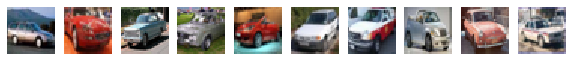

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# The Function used to plot 3-Channel images
def Plot_Img(n,k,n_c,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k,k,n_c))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
Plot_Img(10,32,3,x_train,10,10)

**Training Loop**

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss:  0.7033092975616455
generator loss:  0.6923499


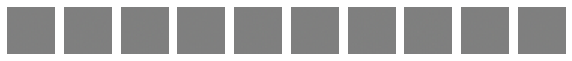

discriminator loss:  0.6730535421185865
generator loss:  0.82663137


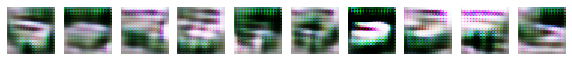

discriminator loss:  0.6825197933020292
generator loss:  0.7909204


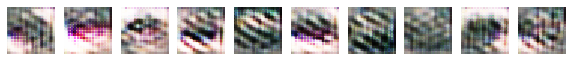

discriminator loss:  0.6864105803937931
generator loss:  0.76916075


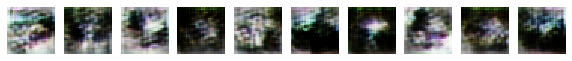

discriminator loss:  0.6886768735598946
generator loss:  0.755896


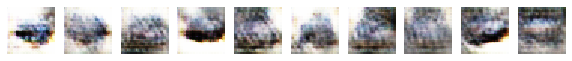

discriminator loss:  0.6896128874809825
generator loss:  0.7479367


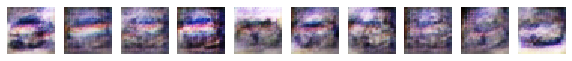

discriminator loss:  0.6898917023220368
generator loss:  0.7442075


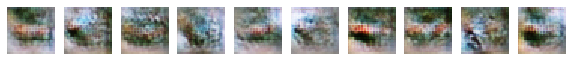

discriminator loss:  0.6896841202130218
generator loss:  0.74508274


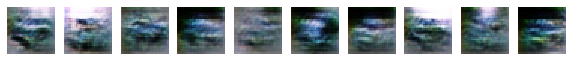

discriminator loss:  0.6894114017263111
generator loss:  0.74721104


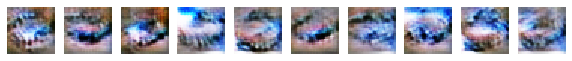

discriminator loss:  0.6887906461828313
generator loss:  0.7519411


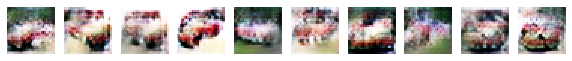

discriminator loss:  0.6880691113280811
generator loss:  0.7571548


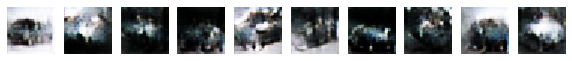

discriminator loss:  0.6873697285228719
generator loss:  0.76148105


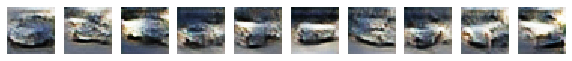

discriminator loss:  0.6869096992324142
generator loss:  0.76377


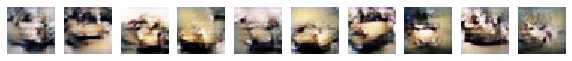

discriminator loss:  0.6861918612574269
generator loss:  0.7659703


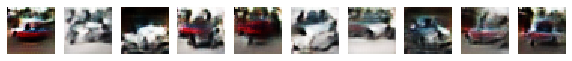

discriminator loss:  0.6856310714731692
generator loss:  0.76786363


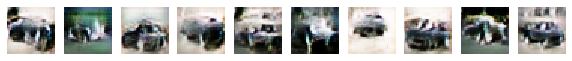

discriminator loss:  0.6850378377098129
generator loss:  0.769067


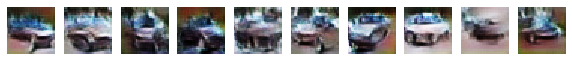

discriminator loss:  0.6840697391981364
generator loss:  0.77178043


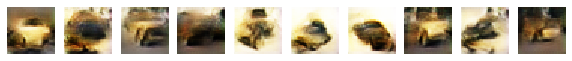

discriminator loss:  0.6826634165462697
generator loss:  0.776294


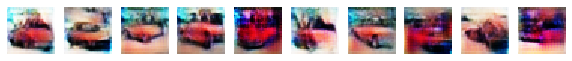

discriminator loss:  0.6814351135254595
generator loss:  0.7800294


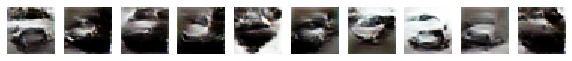

discriminator loss:  0.680266729327531
generator loss:  0.7829263


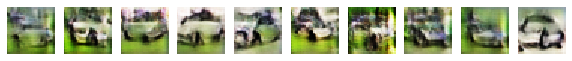

discriminator loss:  0.679474298557202
generator loss:  0.7852215


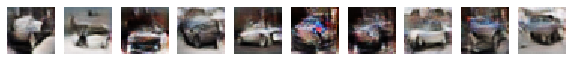

discriminator loss:  0.6796707734557835
generator loss:  0.78464097


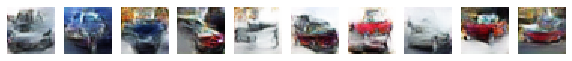

discriminator loss:  0.6797516243440023
generator loss:  0.7843939


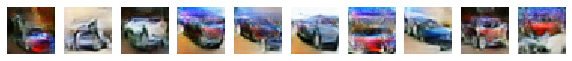

discriminator loss:  0.6799990791707917
generator loss:  0.7830559


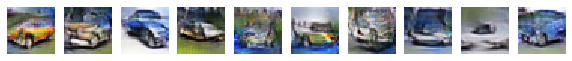

discriminator loss:  0.6803108665453633
generator loss:  0.7818699


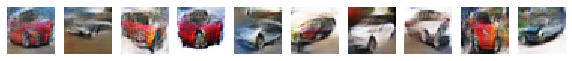

discriminator loss:  0.6804462093566381
generator loss:  0.78098214


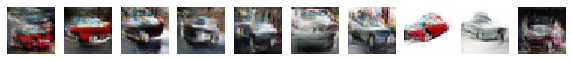

discriminator loss:  0.6805152919313355
generator loss:  0.78054285


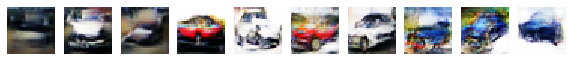

discriminator loss:  0.6806202698205102
generator loss:  0.77977383


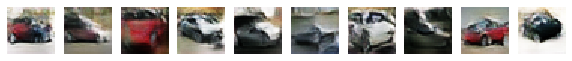

discriminator loss:  0.6805984737953793
generator loss:  0.7793545


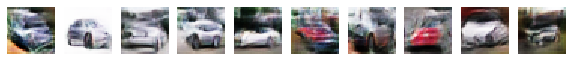

discriminator loss:  0.680380242319816
generator loss:  0.77978706


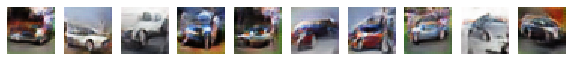

discriminator loss:  0.6802448010903169
generator loss:  0.7794338


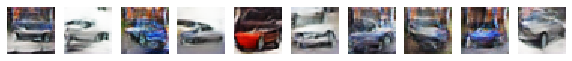

discriminator loss:  0.6802453370576796
generator loss:  0.7792258


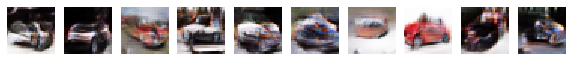

discriminator loss:  0.6801522582141721
generator loss:  0.7790561


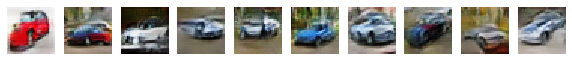

discriminator loss:  0.6800485884797955
generator loss:  0.77887833


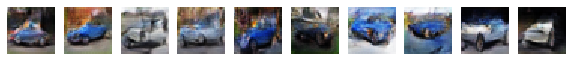

discriminator loss:  0.6799114643896365
generator loss:  0.7788585


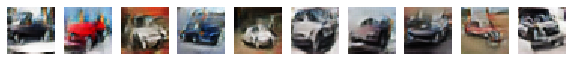

discriminator loss:  0.6796852532359343
generator loss:  0.77891076


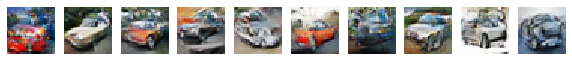

discriminator loss:  0.6795460326006979
generator loss:  0.7788682


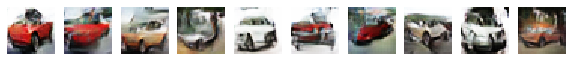

discriminator loss:  0.6794117602388458
generator loss:  0.7789005


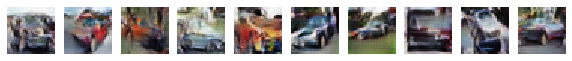

discriminator loss:  0.6792959867339468
generator loss:  0.7789252


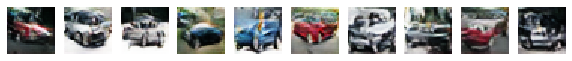

discriminator loss:  0.679007822701848
generator loss:  0.7792758


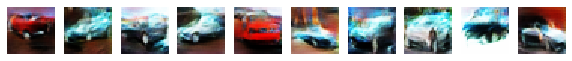

In [8]:
iterations = 20000
batch_size = 20
loss_d = []
loss_gan = []

# Scale the original image digits in the range of -1 to 1
x_train = x_train.reshape((x_train.shape[0],)+
                          (height,width,channels)).astype('float32')/127.5 - 1.

# Set up the GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

# The training loop
for step in range(iterations):
  
    # Random select a batch of images from the training dataset
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    # Random digits used for generate the images
    random_h = np.random.normal(size=(batch_size,h_dim))
    
    # The generated images
    generated_imgs = generator.predict(random_h)
    
    # The real images will be labeled 1 and the fakes are labeled 0
    labels_real = np.ones((batch_size,1))
    labels_fake = np.zeros((batch_size,1))
    
    # Train the discriminator.
    # Train the real images first and then the fake images
    d_loss_real = discriminator.train_on_batch(real_imgs,labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_imgs,labels_fake)
    # The avaeraged lose for one batch of training
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Random digits used to train the generator
    random_h = np.random.normal(size=(batch_size,h_dim))
    
    # Train the generator by holding the discriminator frozen
    g_loss = gan.train_on_batch(random_h,labels_real)
        
    loss_d.append(d_loss)
    loss_gan.append(g_loss)
    
    # Every 500 random batches trained, show the generated images
    if step % 500 == 0:
        
        print('discriminator loss: ', np.mean(loss_d))
        print('generator loss: ', np.mean(loss_gan))
        
        # Scale the images back to 0 to 1
        generated_imgs = (generated_imgs + 1.)/2.
        
        # Display 10 generated images
        Plot_Img(10,32,3,generated_imgs,10,10)

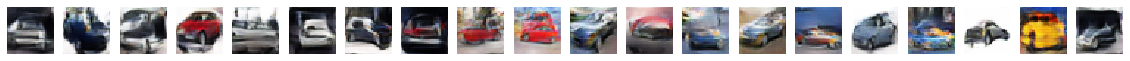

In [16]:
Plot_Img(20,32,3,((generated_imgs + 1.)/2.),20,10)